#Forecasting Droughts through Weather and Soil Data

_________________

_______________________________________

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### <font color='green'> Imports

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

from itertools import zip_longest
from sklearn.datasets import make_classification
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

__________

### <font color='green'> Input Data

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive', force_remount=True)

file_path = '/content/drive/MyDrive/Drought dataset/train_timeseries.csv'
data = pd.read_csv(file_path)
file_path

Mounted at /content/drive


'/content/drive/MyDrive/Drought dataset/train_timeseries.csv'

In [ ]:
#FIPS based on County in US

unique_fips_counts = data['fips'].value_counts()

print("Unique FIPS Values and Their Counts:")
print(f"Total Number of Counties present in the dataset for the US based on FIPS: {unique_fips_counts.count()}\n")
print("Some FIPS Values and Their Counts:")
unique_fips_counts

Unique FIPS Values and Their Counts:
Total Number of Counties present in the dataset for the US based on FIPS: 3108

Some FIPS Values and Their Counts:


1001     6210
39159    6210
39115    6210
39117    6210
39119    6210
         ... 
21159    6210
21161    6210
21163    6210
21165    6210
56043    6210
Name: fips, Length: 3108, dtype: int64

In [ ]:
#Here I took washington Country as data_ts for the forecasting

data_ts = pd.DataFrame(data[data['fips'] == 12133])

data_ts.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
2216970,12133,2000-01-01,0.27,101.56,10.79,16.27,15.34,15.34,22.99,11.85,...,16.05,2.94,3.88,2.28,1.59,5.13,5.77,3.74,2.03,NaN
2216971,12133,2000-01-02,0.28,101.63,11.30,17.25,16.11,16.11,23.60,12.81,...,17.05,3.25,4.42,2.46,1.95,5.56,6.40,4.20,2.20,NaN
2216972,12133,2000-01-03,0.94,101.35,11.14,17.52,15.83,15.82,23.99,12.71,...,17.36,4.05,5.90,3.01,2.89,6.87,7.99,4.40,3.59,NaN
2216973,12133,2000-01-04,5.40,101.23,8.79,15.50,10.88,10.89,20.30,5.72,...,15.36,5.77,7.08,4.54,2.54,8.68,9.46,7.77,1.69,1.0
2216974,12133,2000-01-05,0.00,102.05,3.45,5.69,-1.17,-1.11,12.28,0.57,...,6.09,3.37,4.91,1.99,2.92,5.34,7.82,3.16,4.66,NaN


_________________________________

In [ ]:
# summary statistics of the dataset

display(data_ts.describe())

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
count,6210.0,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,6210.000000,887.000000
mean,12133.0,3.806164,101.211016,11.555084,19.411485,14.822718,14.829671,25.096006,14.170663,10.925396,19.578899,3.102958,4.514296,1.808010,2.706348,4.900522,6.748767,2.969655,3.779097,0.884449
std,0.0,8.394451,0.476185,4.765635,7.552779,7.584027,7.570020,7.179591,8.182484,3.271726,7.682839,1.196126,1.721266,0.970928,1.216880,1.762855,2.001181,1.830081,1.456099,1.312806
min,12133.0,0.000000,99.110000,1.710000,-4.060000,-10.010000,-9.700000,-1.410000,-7.650000,2.110000,-2.820000,0.820000,1.280000,0.020000,0.390000,1.170000,1.950000,0.020000,0.930000,0.000000
25%,12133.0,0.000000,100.900000,7.470000,13.872500,9.482500,9.490000,20.290000,7.722500,8.620000,13.842500,2.240000,3.200000,1.070000,1.840000,3.590000,5.460000,1.440000,2.742500,0.000000
50%,12133.0,0.310000,101.180000,11.735000,20.535000,16.550000,16.550000,26.190000,15.145000,10.940000,20.550000,2.895000,4.220000,1.830000,2.480000,4.690000,6.430000,2.790000,3.580000,0.000000
75%,12133.0,3.810000,101.500000,15.797500,26.050000,21.330000,21.330000,30.790000,21.970000,13.280000,26.180000,3.760000,5.507500,2.460000,3.290000,6.007500,7.660000,4.287500,4.570000,1.273700
max,12133.0,100.760000,103.410000,20.900000,32.840000,25.830000,25.830000,40.270000,27.370000,21.850000,33.820000,12.510000,17.070000,8.400000,11.200000,17.350000,22.760000,11.510000,13.830000,5.000000


In [ ]:
def categorical_numerical_table(data):
    """
    Creates a table with categorical and numerical column names from a DataFrame.
    """
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
    aligned_columns = list(zip_longest(categorical_columns, numeric_columns, fillvalue=''))
    column_table = pd.DataFrame({'Numerical Columns': [num_col for cat_col, num_col in aligned_columns],
                                 'Categorical Columns': [cat_col for cat_col, num_col in aligned_columns],
                                 },
                                index=range(1, len(aligned_columns) + 1))

    return column_table

numerical_columns = categorical_numerical_table(data)['Numerical Columns'].tolist()
categorical_columns = categorical_numerical_table(data)['Categorical Columns'].tolist()

print("Note: I will convert the date into date type in the preprocessing.\n\n")
categorical_numerical_table(data_ts)

Note: I will convert the date into date type in the preprocessing.




,Numerical Columns,Categorical Columns
1,fips,date
2,PRECTOT,
3,PS,
4,QV2M,
5,T2M,
6,T2MDEW,
7,T2MWET,
8,T2M_MAX,
9,T2M_MIN,
10,T2M_RANGE,


In [ ]:
#Checking for the Null

data_ts.isnull().sum()

fips              0
date              0
PRECTOT           0
PS                0
QV2M              0
T2M               0
T2MDEW            0
T2MWET            0
T2M_MAX           0
T2M_MIN           0
T2M_RANGE         0
TS                0
WS10M             0
WS10M_MAX         0
WS10M_MIN         0
WS10M_RANGE       0
WS50M             0
WS50M_MAX         0
WS50M_MIN         0
WS50M_RANGE       0
score          5323
dtype: int64

In [ ]:
#Duplicates from the dataset

data_ts[data_ts.duplicated()]

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score


In [ ]:
#Shape of the data_ts

data_ts.shape

(6210, 21)

In [ ]:
#Converting date from object type to date type

data_ts['date'] = pd.to_datetime(data_ts['date'])



#Extracting Day, Month and Year for the Analysis

data_ts['year'] = pd.DatetimeIndex(data_ts['date']).year
data_ts['month'] = pd.DatetimeIndex(data_ts['date']).month
data_ts['day'] = pd.DatetimeIndex(data_ts['date']).day

data_ts.dtypes

fips                    int64
date           datetime64[ns]
PRECTOT               float64
PS                    float64
QV2M                  float64
T2M                   float64
T2MDEW                float64
T2MWET                float64
T2M_MAX               float64
T2M_MIN               float64
T2M_RANGE             float64
TS                    float64
WS10M                 float64
WS10M_MAX             float64
WS10M_MIN             float64
WS10M_RANGE           float64
WS50M                 float64
WS50M_MAX             float64
WS50M_MIN             float64
WS50M_RANGE           float64
score                 float64
year                    int64
month                   int64
day                     int64
dtype: object

In [ ]:
#Backward Filling for the Null values

data_ts['score'] = data_ts['score'].fillna(method='bfill')

__________________________________

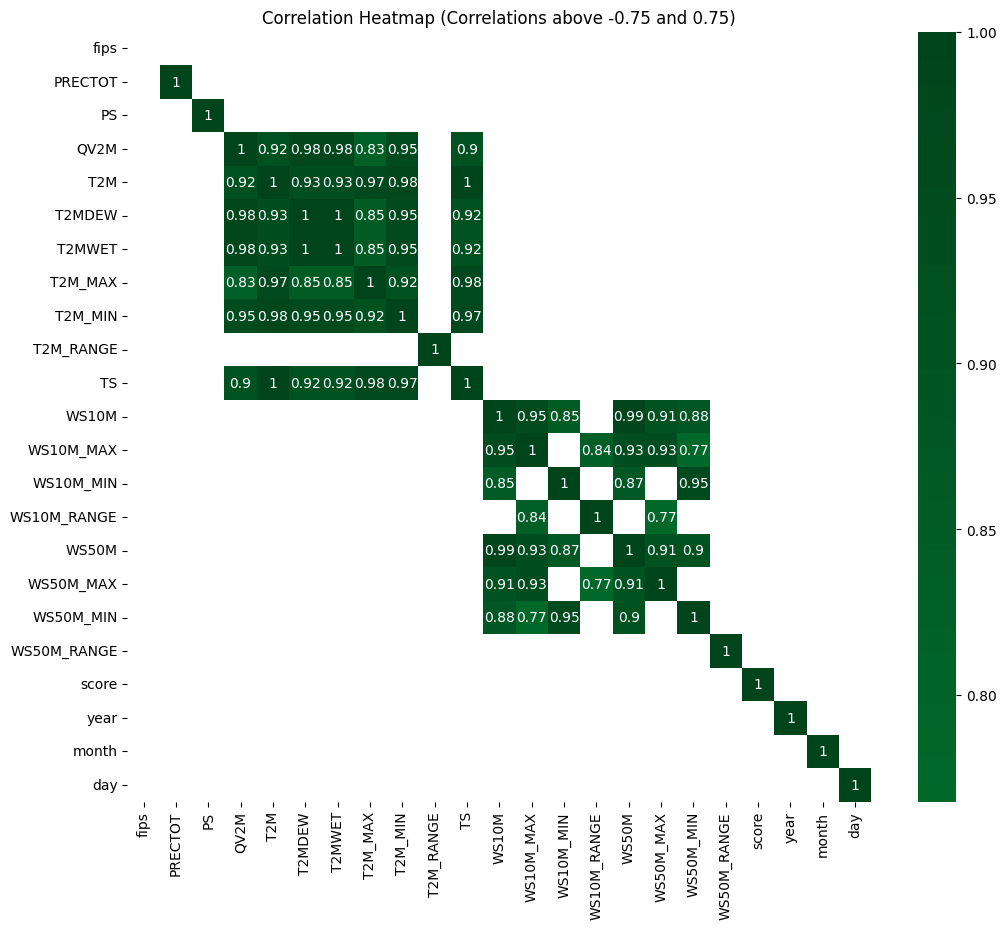

In [ ]:
# Heatmap with the feature correlation that are highly correlated above 0.57 in the positive and negaive range.

correlation_matrix = data_ts.corr()

filtered_correlations = correlation_matrix[(correlation_matrix <= -0.75) | (correlation_matrix >= 0.75)]

plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlations, annot=True, cmap='Greens', center=0)
plt.title("Correlation Heatmap (Correlations above -0.75 and 0.75)")
plt.show()

____________________________

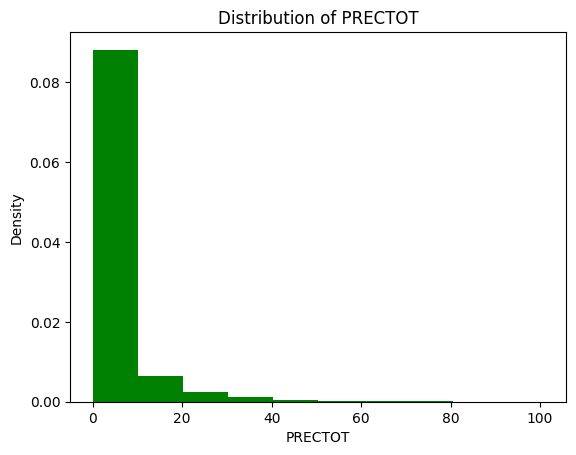

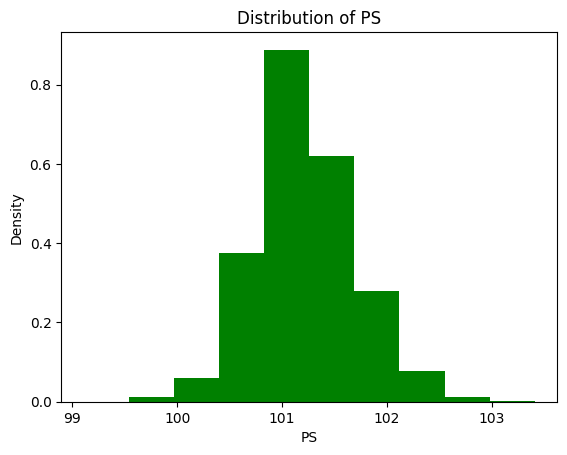

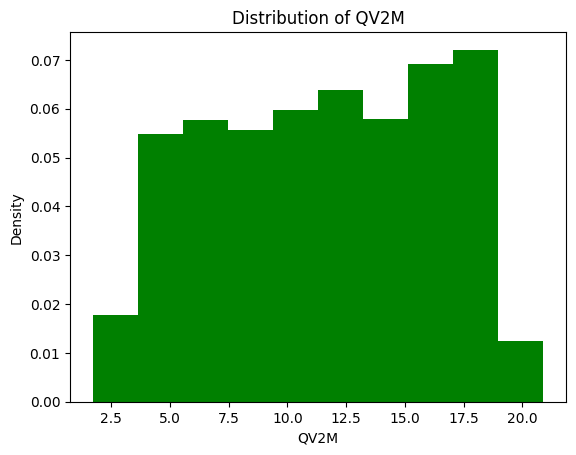

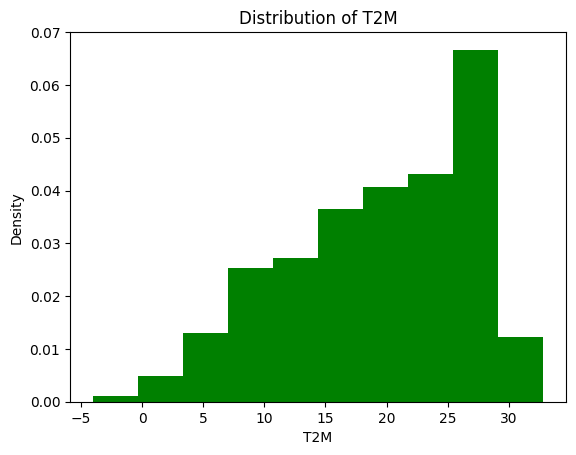

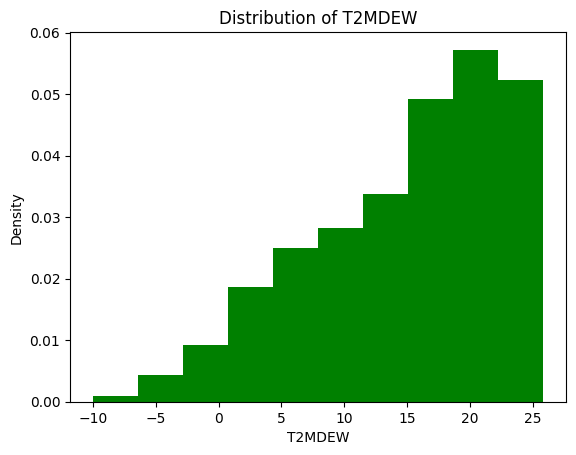

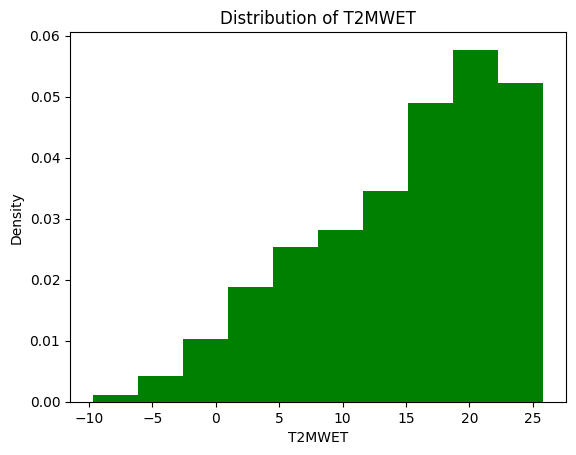

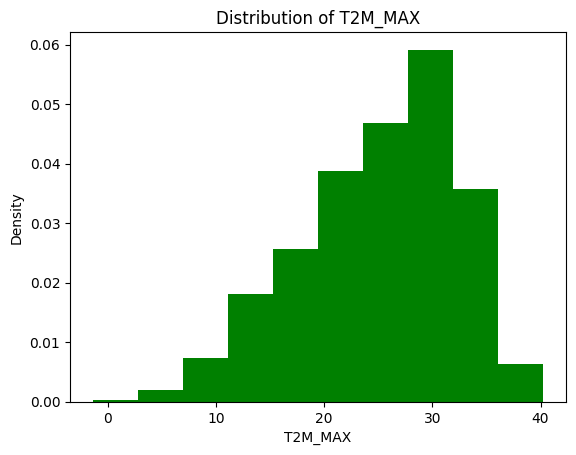

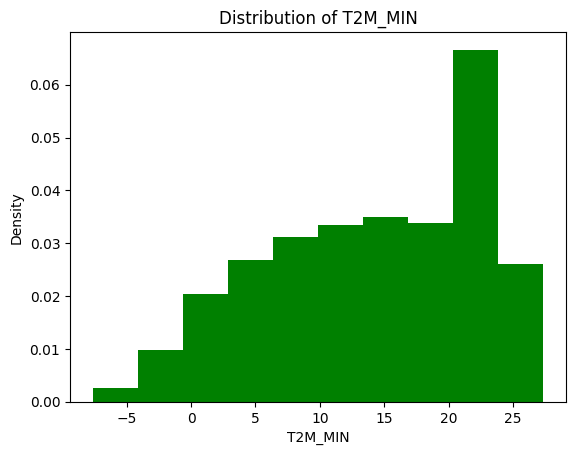

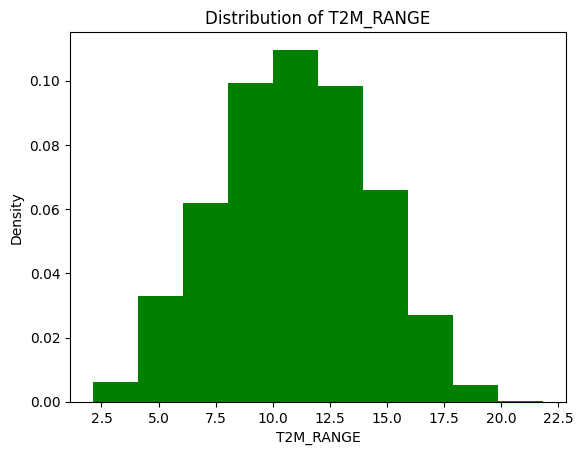

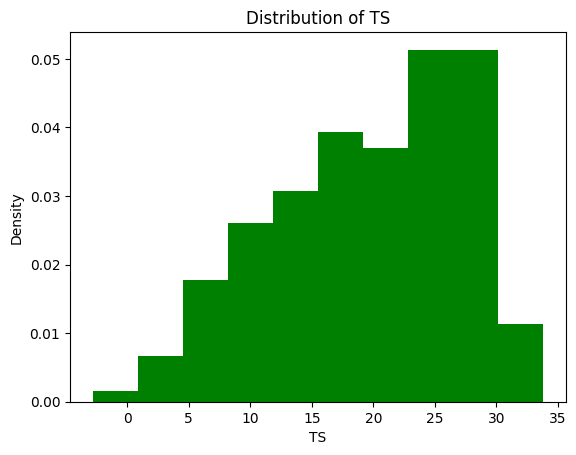

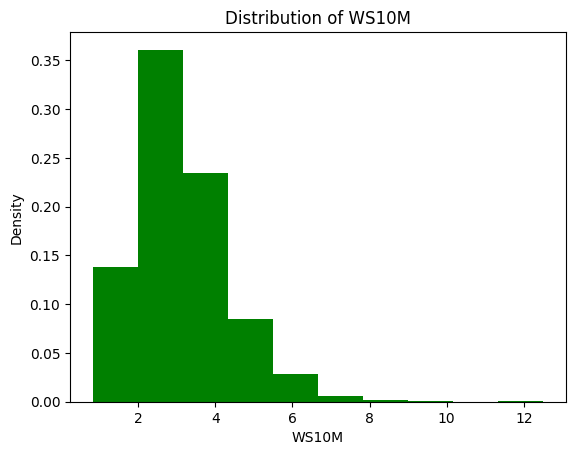

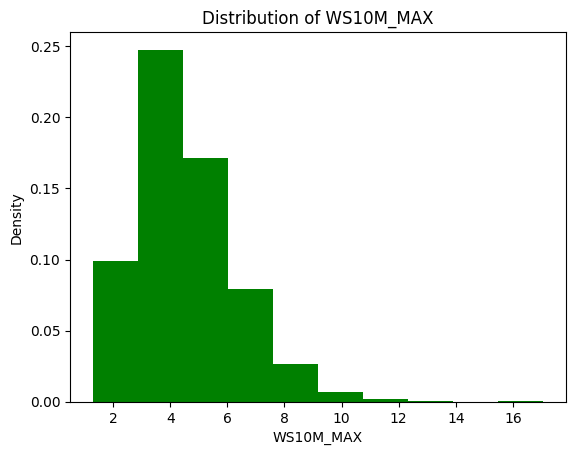

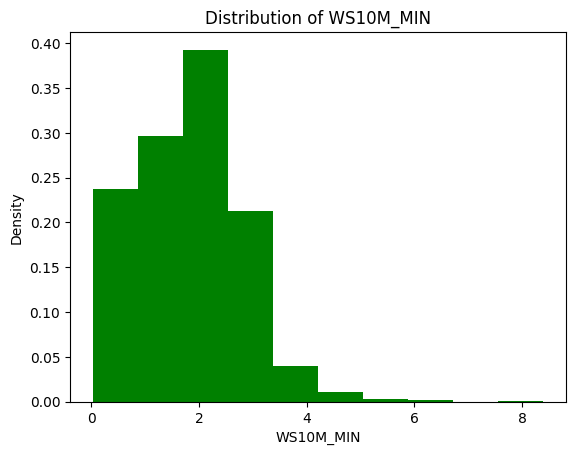

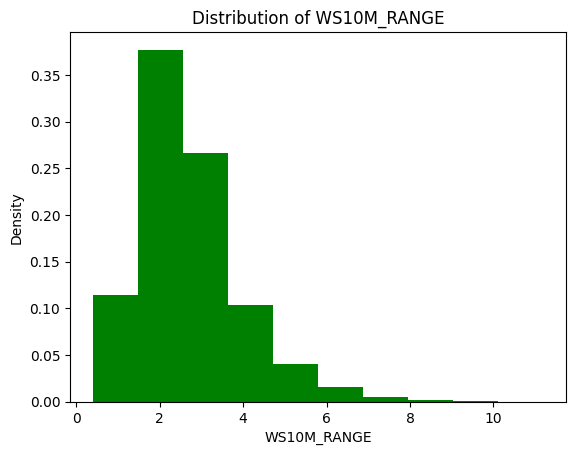

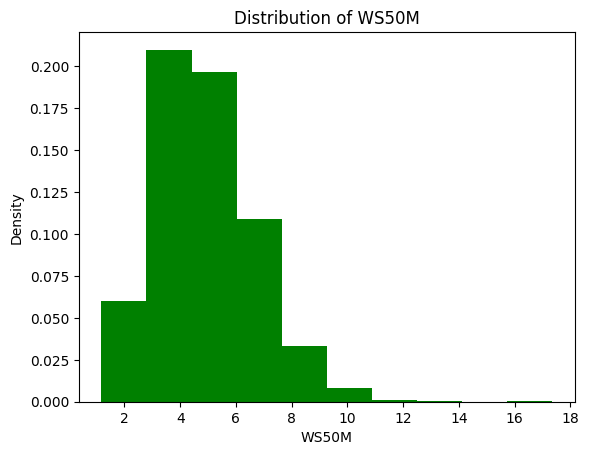

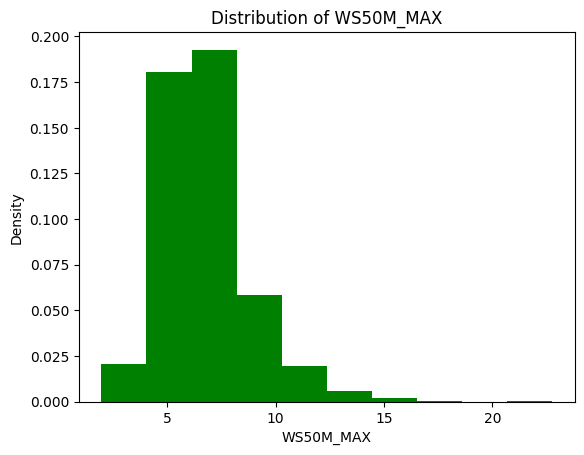

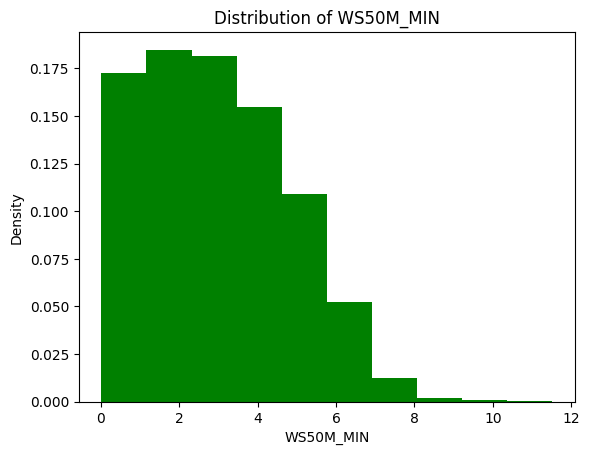

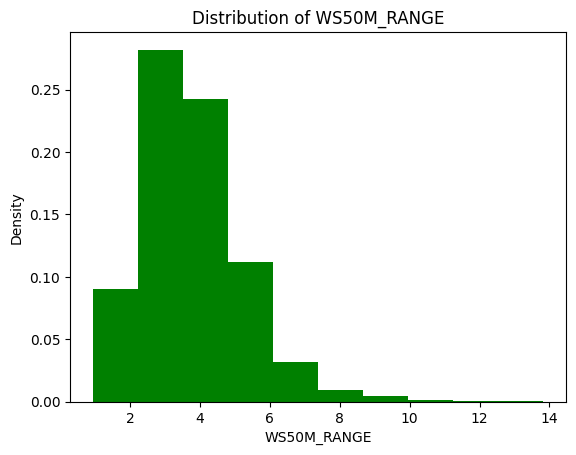

In [ ]:
#Distribution of all the continuous variables

measures_column_list = ['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']
data_ts_measures = data_ts[['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']]

for col_name in measures_column_list:
    plt.figure()
    plt.hist(data_ts_measures[col_name], density = True, color = 'green')
    x_name = col_name
    plt.xlabel(x_name)
    y_name = 'Density'
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))

_________________________

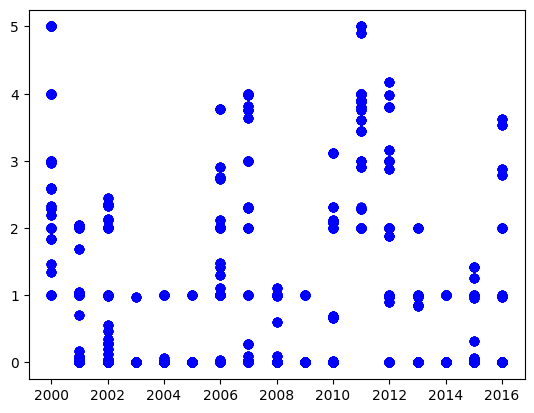

In [ ]:
#Scatter Plot for the Year and Score

plt.scatter(data_ts['year'], data_ts['score'], c ="blue")
plt.show()

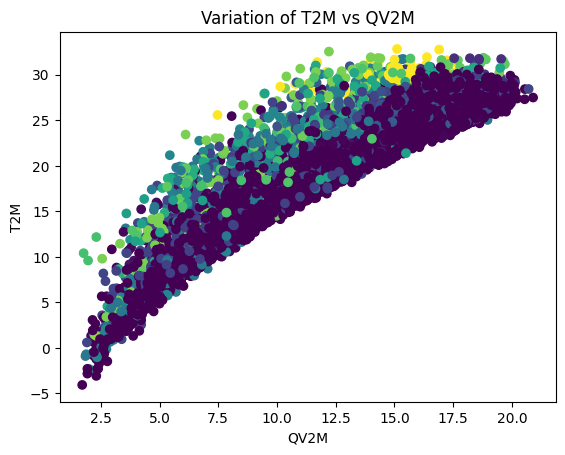

In [ ]:
plt.scatter(data_ts['QV2M'], data_ts['T2M'], c =data_ts['score'])
plt.xlabel('QV2M')
plt.ylabel('T2M')
plt.title('Variation of T2M vs QV2M')
plt.show()

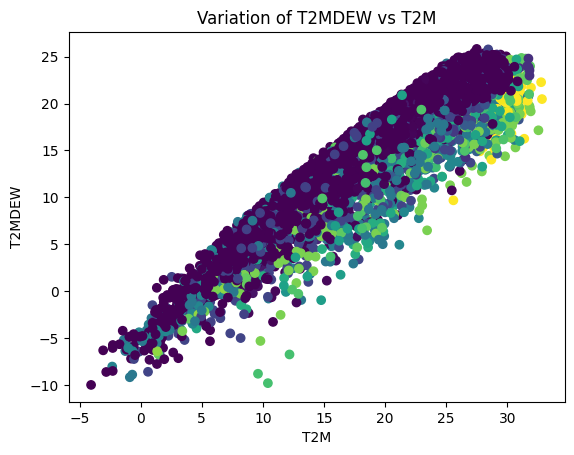

In [ ]:
plt.scatter(data_ts['T2M'], data_ts['T2MDEW'], c =data_ts['score'])
plt.xlabel('T2M')
plt.ylabel('T2MDEW')
plt.title('Variation of T2MDEW vs T2M')
plt.show()

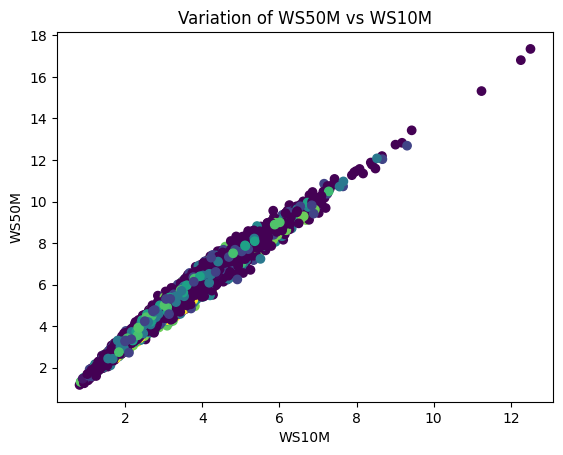

In [ ]:
temp_df = data_ts[data_ts['score']==5]
plt.scatter(data_ts['WS10M'], data_ts['WS50M'], c= data_ts['score'])
plt.xlabel('WS10M')
plt.ylabel('WS50M')
plt.title('Variation of WS50M vs WS10M')
plt.show()

_____________________

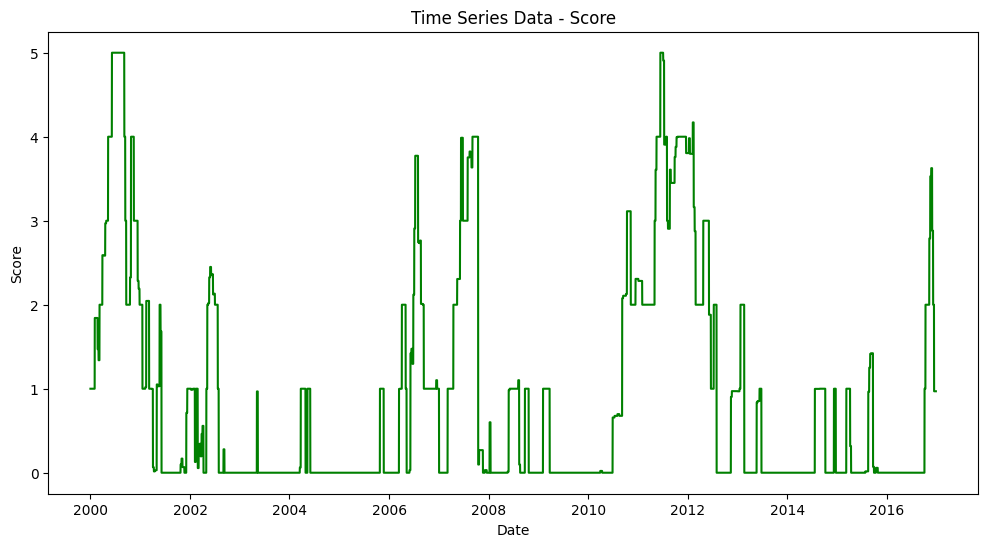

In [ ]:
#Pattern of score over the years

plt.figure(figsize=(12, 6))
plt.plot(data_ts['date'], data_ts['score'], color = 'green')
plt.title('Time Series Data - Score')
plt.xlabel('Date')
plt.ylabel('Score')
plt.show()

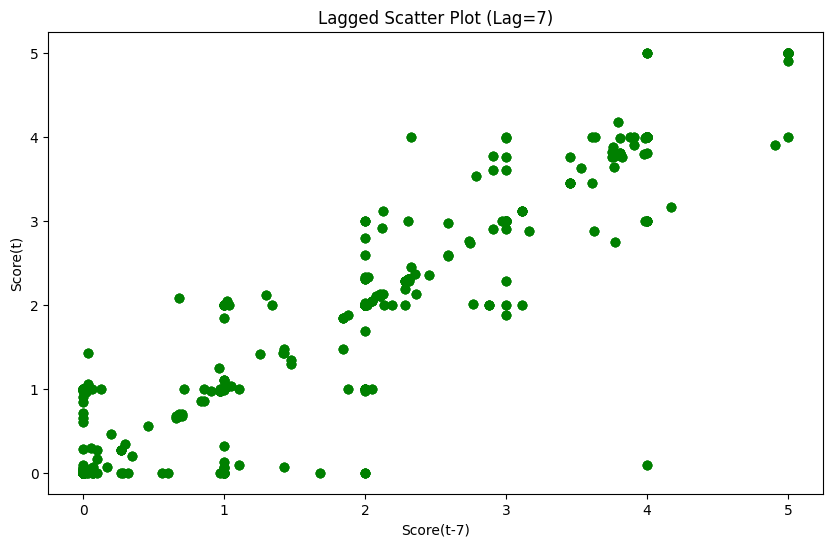

In [ ]:
#Scatter plot with the lag of 7 (week)

lag = 7
plt.figure(figsize=(10, 6))
plt.scatter(data_ts['score'].shift(lag), data_ts['score'], alpha=0.5, color = 'green')
plt.title(f'Lagged Scatter Plot (Lag={lag})')
plt.xlabel(f'Score(t-{lag})')
plt.ylabel('Score(t)')
plt.show()

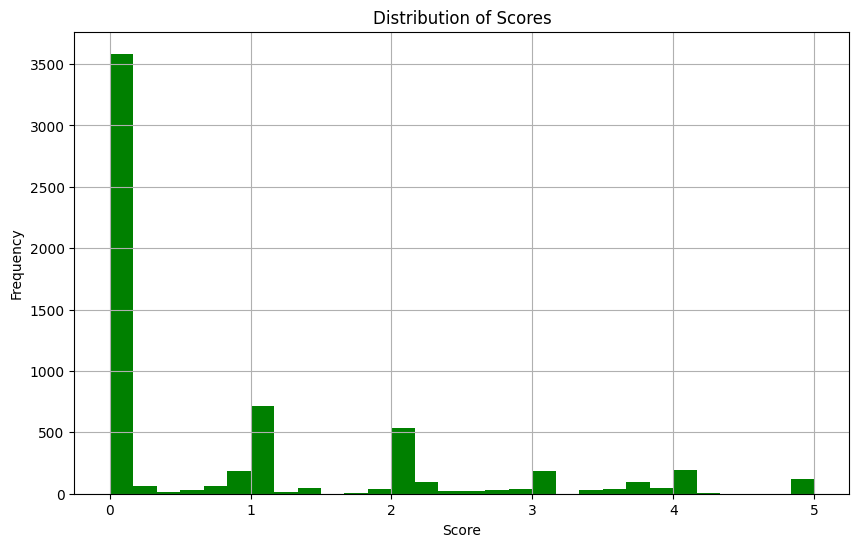

In [ ]:
#Scores Distribution Plot

plt.figure(figsize=(10, 6))
data_ts['score'].hist(bins=30, color = 'green')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

__________________________________


Skewness: 
 fips           0.000000
PRECTOT        4.333936
PS             0.270360
QV2M          -0.111058
T2M           -0.534681
T2MDEW        -0.707009
T2MWET        -0.700946
T2M_MAX       -0.535863
T2M_MIN       -0.425596
T2M_RANGE     -0.028133
TS            -0.446801
WS10M          1.139381
WS10M_MAX      1.053074
WS10M_MIN      0.486575
WS10M_RANGE    1.290574
WS50M          0.770819
WS50M_MAX      1.347562
WS50M_MIN      0.455466
WS50M_RANGE    1.176677
score          1.462909
year           0.000000
month         -0.009091
day            0.006626
dtype: float64


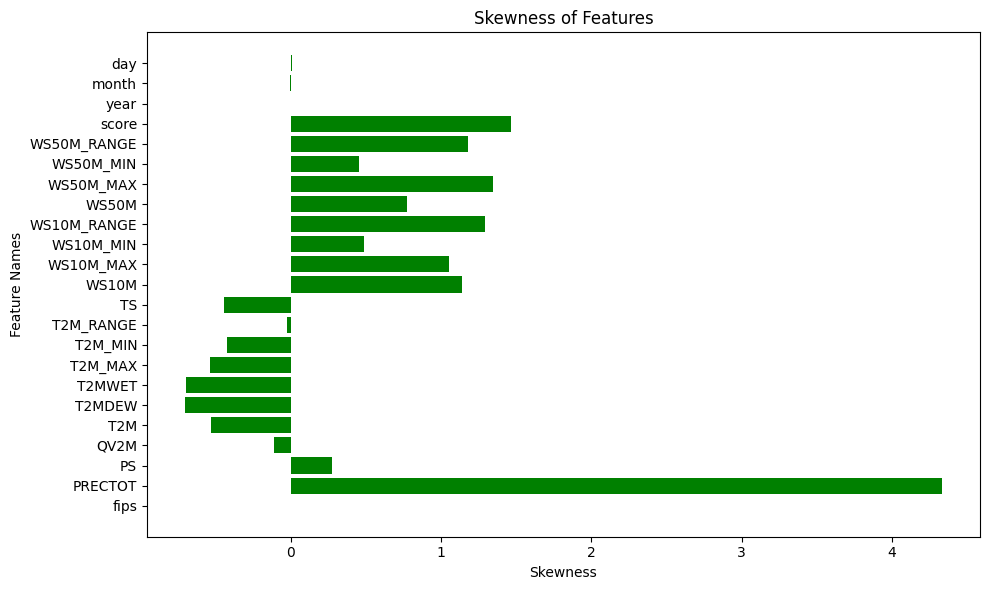

In [ ]:
skewness_result = data_ts.skew(axis=0, skipna=True)
feature_names = skewness_result.index.tolist()
skewness_values = skewness_result.tolist()


print("\nSkewness: \n", skewness_result)


plt.figure(figsize=(10, 6))
plt.barh(feature_names, skewness_values, color='green')
plt.xlabel('Skewness')
plt.ylabel('Feature Names')
plt.title('Skewness of Features')
plt.tight_layout()

# Display the plot
plt.show()

_________________________________


Kurtosis: 
 fips            0.000000
PRECTOT        26.181618
PS              0.524885
QV2M           -1.172422
T2M            -0.671873
T2MDEW         -0.399735
T2MWET         -0.419116
T2M_MAX        -0.346157
T2M_MIN        -0.947546
T2M_RANGE      -0.479844
TS             -0.765866
WS10M           2.678207
WS10M_MAX       1.829231
WS10M_MIN       1.088171
WS10M_RANGE     2.641266
WS50M           1.264271
WS50M_MAX       3.838515
WS50M_MIN      -0.394375
WS50M_RANGE     2.994370
score           1.144530
year           -1.208311
month          -1.208240
day            -1.194180
dtype: float64


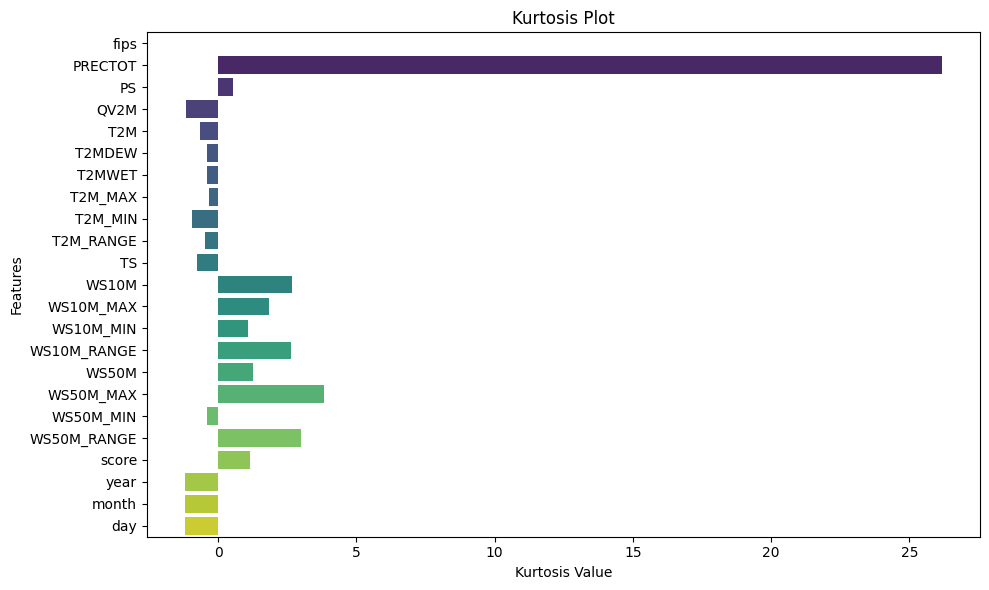

In [ ]:
kurtosis_result = data_ts.kurtosis(axis=0, skipna=True)
feature_names = kurtosis_result.index.tolist()
kurtosis_values = kurtosis_result.tolist()


print("\nKurtosis: \n", kurtosis_result)


plt.figure(figsize=(10, 6))
sns.barplot(x=kurtosis_values, y=feature_names, palette='viridis')
plt.title('Kurtosis Plot')
plt.xlabel('Kurtosis Value')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

________________________________________

In [ ]:
#Removing Outliers based on the five outlier detection models along with ranged parameters

models = [
    ('Isolation Forest', IsolationForest(contamination=0.05, random_state=10)),
    ('Local Outlier Factor', LocalOutlierFactor(contamination=0.05)),
    ('One-Class SVM', OneClassSVM(nu=0.05)),
    ('Elliptic Envelope', EllipticEnvelope(contamination=0.05)),
    ('DBSCAN', DBSCAN(eps=0.5, min_samples=5))
]

#Outliers are removed based on the threshold. This can be adjusted accordingly.

threshold = 2.5

outlier_indices = {}

for name, model in models:
    if name == 'DBSCAN':
        labels = model.fit_predict(data_ts.drop(columns=['date', 'score']))
        scores = -labels  # Using labels for DBSCAN (DBSCAN doesn't have negative_outlier_factor_)
    else:
        scores = model.fit_predict(data_ts.drop(columns=['date', 'score']))
        scores = -scores
    outlier_indices[name] = data_ts.index[scores > threshold]

all_outlier_indices = np.concatenate(list(outlier_indices.values()))

data_without_outliers = data_ts.drop(index=all_outlier_indices)

_____________________________

In [ ]:
X = data_without_outliers.drop(columns=['date', 'score'])
y = data_without_outliers['score']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

_______________________

In [ ]:
#SARIMAX Model building

sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_fit = sarima_model.fit()

In [ ]:
#Prediction of y_train

sarima_predictions = sarima_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)
sarima_predictions

4347    0.868494
4348    1.021710
4349    0.914308
4350    0.958690
4351    0.950215
          ...   
6205    0.965577
6206    0.957339
6207    0.864237
6208    0.975170
6209    0.885216
Name: predicted_mean, Length: 1863, dtype: float64

In [ ]:
#Evalucation Metrics

mse_sarima = mean_squared_error(y_test, sarima_predictions)
rmse_sarima = np.sqrt(mse_sarima)
mae_sarima = mean_absolute_error(y_test, sarima_predictions)


print("SARIMA Model Metrics:")
print("Mean Squared Error:", mse_sarima)
print("Root Mean Squared Error:", rmse_sarima)
print("Mean Absolute Error:", mae_sarima)

SARIMA Model Metrics:
Mean Squared Error: 1.7885109327629574
Root Mean Squared Error: 1.3373522096900865
Mean Absolute Error: 1.0594363118486703


In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming df2 is your DataFrame
independent_variable = 'T2M_MAX'
dependent_variable = 'QV2M'

x = data[independent_variable].values.reshape(-1, 1)
y = data[dependent_variable].values

# Decision Tree Regression model
model = DecisionTreeRegressor()
model.fit(x, y)

# Predictions
model_predictions = model.predict(x)

# Calculate Evaluation Metrics
mse_decision_tree = mean_squared_error(y, model_predictions)
rmse_decision_tree = np.sqrt(mse_decision_tree)
mae_decision_tree = mean_absolute_error(y, model_predictions)

# Print Metrics
print("Mean Squared Error:", mse_decision_tree)
print("Root Mean Squared Error:", rmse_decision_tree)
print("Mean Absolute Error:", mae_decision_tree)

Mean Squared Error: 6.592059557051113
Root Mean Squared Error: 2.5675006440215573
Mean Absolute Error: 1.85803036380427


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid

# Assuming y_train and y_test are your training and testing time series data

# Define a range of hyperparameter values for tuning
param_grid = {
    'order': [(p, d, q) for p in range(2) for d in range(2) for q in range(2)],
    'seasonal_order': [(P, D, Q, s) for P in range(2) for D in range(2) for Q in range(2) for s in [7]],
}

best_mse = float('inf')
best_params = None

# Perform grid search
for params in ParameterGrid(param_grid):
    sarima_model = SARIMAX(y_train, order=params['order'], seasonal_order=params['seasonal_order'])
    sarima_fit = sarima_model.fit()
    sarima_predictions = sarima_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

    mse_sarima = mean_squared_error(y_test, sarima_predictions)

    if mse_sarima < best_mse:
        best_mse = mse_sarima
        best_params = params

# Print the best hyperparameters and corresponding metrics
print("Best SARIMA Model Metrics:")
print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", best_mse)
print("Root Mean Squared Error:", np.sqrt(best_mse))
print("Mean Absolute Error:", mean_absolute_error(y_test, sarima_predictions))

Best SARIMA Model Metrics:
Best Hyperparameters: {'order': (0, 1, 1), 'seasonal_order': (0, 1, 1, 7)}
Mean Squared Error: 1.7882168572253687
Root Mean Squared Error: 1.3372422582409549
Mean Absolute Error: 1.0594363118486703
